### Гиперпараметры

In [230]:
device_id = 0
if torch.cuda.is_available() == True:
    device = f'cuda:{device_id}'
elif torch.backends.mps.is_available() == True:
    device = 'mps'
else:
    device = 'cpu'

#model_name = 'resnet152_bg100_tvs_full_colorjitter_04_03_03_resizedcrop_085_1_erasing_adam_001'
#model_name = 'resnet152_bg100_tvs_randomchoice_perspective_colorjitter_resizedcrop_erasing_adam_001'
#model_name = 'resnet152_bg100_alb_full_brightnesscontrast_03_03_p08_fog_p005_rain_p005_rotate_10_p05_adam_001'
model_name = 'resnet152_bg100_alb_full_brightnesscontrast_03_03_p08_fog_p005_rain_p005_gaussnoise_001_02_p03_rotate_10_p05_adam_001'
last_epoch = None
n_epochs = 10
batch_size = 32
num_classes = 156

device

'cuda:0'

### Инициализация модели, задание оптимизатора и функции потерь

In [231]:
def create_model(num_classes):
    model = resnet152(weights='ResNet152_Weights.IMAGENET1K_V2')
    for param in model.parameters():
        param.requires_grad = False
    
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    #model.fc = nn.Sequential(nn.Linear(2048, 1024), nn.Linear(1024, num_classes))
    #model.fc = nn.Sequential(nn.Linear(2048, num_classes))
    for param in model.fc.parameters():
        param.requires_grad = True

    #torchvision.models.detection.fasterrcnn_resnet50_fpn(weights='FasterRCNN_ResNet50_FPN_Weights.COCO_V1')
    #in_features = model.roi_heads.box_predictor.cls_score.in_features
    #model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

In [ ]:
checkpoint = torch.load(os.path.join(checkpoints_path, f'chkpt_classifier_{model_name}_{last_epoch}.pth'), map_location=device)

In [ ]:
checkpoint.keys()

dict_keys(['epoch', 'model_state_dict', 'optimizer_state_dict', 'losses_train', 'losses_val'])

In [232]:
model = create_model(num_classes).to(device)

loss_function = nn.CrossEntropyLoss()

# parameters
params = [p for p in model.parameters() if p.requires_grad]
#optimizer = torch.optim.SGD(params, lr=0.001, momentum=0.9, weight_decay=0.0005)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
#params = [p for p in model.parameters() if p.requires_grad]
#optimizer = torch.optim.SGD(params, lr=0.003, momentum=0.9, weight_decay=0.0005)
#optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9, weight_decay=0.0005)
#optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=0.0005)


#optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
    # and a learning rate scheduler
#lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.9)


# Загрузка весов модели, состояния оптимизатора и шедулера
if last_epoch is not None:
    checkpoint = torch.load(os.path.join(checkpoints_path, f'chkpt_classifier_{model_name}_{last_epoch}.pth'), map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    #lr_scheduler.load_state_dict(checkpoint['lr_scheduler_state_dict'])

train_dataset = RTSD_dataset_classifier(dataset_path,
                                        background_anno_file = 'train_anno_reduced_background.json',
                                        dataset_anno_file = 'train_anno.json',
                                        transforms = get_transform(augmentation_lib = 'albumentations', train=True)
                                        )

val_dataset = RTSD_dataset_classifier(dataset_path,
                                      background_anno_file = 'val_anno_background.json',
                                      dataset_anno_file = 'val_anno.json',
                                      transforms = get_transform(augmentation_lib = 'albumentations', train=False),
                                      background_size=100
                                      )

train_data_loader = DataLoader(
    train_dataset,
    #sampler=SubsetRandomSampler(),
    batch_size=batch_size,
    shuffle=True,
    #num_workers=4,
    #collate_fn=collate_fn
)

val_data_loader = DataLoader(
    val_dataset,
    #sampler=SubsetRandomSampler(),
    batch_size=batch_size,
    shuffle=False,
    #num_workers=4,
    #collate_fn=collate_fn
)

### Трейн луп

In [233]:
def train(train_dataloader, epoch): 
    len_dataloader = len(train_dataloader)

    training_loss=0
    # для текущего accuracy
    correct = 0.0
    total = 0.0
    # для вывода метрик
    y_true = []
    y_pred = []

    model.train()
    running_loss = 0        # training_loss
    
    for batch_idx, data in enumerate(train_dataloader):
        
        
        
        optimizer.zero_grad()
        #images, targets = data[0], data[1]
        #images = images.to(device)
        #targets = targets.to(device)
        images = data['images'].to(device)
        targets = data['labels'].to(device)
        output = model(images)
        loss = loss_function(output, targets)
        loss.backward()
        optimizer.step()
       
        running_loss = running_loss + ((1/(batch_idx+1))*(loss.data-running_loss))
        if batch_idx%20 == 0:
            print(f"Batch Id {batch_idx} is having training loss of {running_loss}")
            print(loss.item())

        pred = output.data.max(1,keepdim=True)[1]

        # для текущего accuracy
        correct += np.sum(np.squeeze(pred.eq(targets.data.view_as(pred))).cpu().numpy())
        total += images.size(0)
        print(f"Epoch #{epoch}. Accuracy on batch {batch_idx}/{len_dataloader}  on Training is {(100*correct/total)}")
        
        # для вывода метрик
        y_true.extend([int(item) for item in targets])
        y_pred.extend([int(item) for item in pred])

        #images = list(image.to(device) for image in images)
        #targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        #loss_dict = model(images, targets)
        #loss = sum(loss for loss in loss_dict.values())
        #running_loss += loss.item()
        #loss.backward()
        #optimizer.step()
        #if batch_idx % 50 == 0:
        #    print(f"\tЭпоха {epoch}. Итерация {batch_idx}/{len_dataloader}. Loss: {loss}")
    train_loss = running_loss/len(train_dataloader.dataset)
    train_accuracy = metrics.accuracy_score(y_true, y_pred)
    train_f1_micro = metrics.f1_score(y_true, y_pred, average="micro")
    train_f1_macro =  metrics.f1_score(y_true, y_pred, average="macro")
    train_f1_weighted = metrics.f1_score(y_true, y_pred, average="weighted")
    return train_loss, train_accuracy, train_f1_micro, train_f1_macro, train_f1_weighted

In [234]:
def val (val_dataloader, epoch):
    len_dataloader = len(val_dataloader)

    validation_loss=0
    # для текущего accuracy
    correct = 0.0
    total = 0.0
    # для вывода метрик
    y_true = []
    y_pred = []

    model.eval()

    for batch_idx, data in enumerate(val_dataloader):
        
        
        optimizer.zero_grad()
        #images, targets = data[0], data[1]
        #images = images.to(device)
        #targets = targets.to(device)
        images = data['images'].to(device)
        targets = data['labels'].to(device)
        #with torch.no_grad():
            
        output = model(images)
        loss = loss_function(output, targets)
        
        validation_loss = validation_loss + ((1/(batch_idx+1))*(loss.data-validation_loss))
        #if batch_idx%20 == 0:
        print(f"Epoch #{epoch}. Batch Id {batch_idx}/{len_dataloader}  is having validation loss of {validation_loss}")
        print(loss.item())
        pred = output.data.max(1,keepdim=True)[1]

        # для текущего accuracy
        correct += np.sum(np.squeeze(pred.eq(targets.data.view_as(pred))).cpu().numpy())
        total += images.size(0)
        print(f"Epoch #{epoch}. Batch Id {batch_idx}/{len_dataloader}  is having validation accuracy of {(100*correct/total)}")

        # для вывода метрик
        y_true.extend([int(item) for item in targets])
        y_pred.extend([int(item) for item in pred])
        #images = list(image.to(device) for image in images)
        #targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        #loss_dict = model(images, targets)
        #loss = sum(loss for loss in loss_dict.values())
        #running_loss += loss.item()
        #loss.backward()
        #optimizer.step()
        #if batch_idx % 50 == 0:
        #    print(f"\tЭпоха {epoch}. Итерация {batch_idx}/{len_dataloader}. Loss: {loss}")
    val_loss = validation_loss/len(val_dataloader.dataset)
    val_accuracy = metrics.accuracy_score(y_true, y_pred)
    val_f1_micro = metrics.f1_score(y_true, y_pred, average="micro")
    val_f1_macro =  metrics.f1_score(y_true, y_pred, average="macro")
    val_f1_weighted = metrics.f1_score(y_true, y_pred, average="weighted")


    return val_loss, val_accuracy, val_f1_micro, val_f1_macro, val_f1_weighted

In [235]:
# Загрузка словарей с лоссами
if last_epoch is not None:
    train_losses = checkpoint['losses_train']
    val_losses = checkpoint['losses_val']
    train_accuracies = checkpoint['accuracies_train']
    val_accuracies = checkpoint['accuracies_val']
    train_f1_micros = checkpoint['train_f1_micro']
    val_f1_micros = checkpoint['val_f1_micro']
    train_f1_macros = checkpoint['train_f1_macro']
    val_f1_macros = checkpoint['val_f1_macro']
    train_f1_weighteds = checkpoint['train_f1_weighted']
    val_f1_weighteds = checkpoint['val_f1_weighted']
else:
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    train_f1_micros = []
    val_f1_micros = []
    train_f1_macros = []
    val_f1_macros = []
    train_f1_weighteds = []
    val_f1_weighteds = []

if last_epoch is None:
    start_epoch = 0
else:
    start_epoch = last_epoch +1

try:
    for epoch in range(start_epoch, n_epochs):
        start = time.time()
        train_loss, train_accuracy, train_f1_micro, train_f1_macro, train_f1_weighted = train(train_data_loader, epoch)
        val_loss, val_accuracy, val_f1_micro, val_f1_macro, val_f1_weighted = val(val_data_loader, epoch)
        #lr_scheduler.step()
        print(f"Эпоха #{epoch} train_loss: {train_loss}, val_loss: {val_loss}")  
        end = time.time()
        print(f"Потрачено {round((end - start) / 60, 1)} минут на {epoch} эпоху")
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)
        train_f1_micros.append(train_f1_micro)
        val_f1_micros.append(val_f1_micro)
        train_f1_macros.append(train_f1_macro)
        val_f1_macros.append(val_f1_macro)
        train_f1_weighteds.append(train_f1_weighted)
        val_f1_weighteds.append(val_f1_weighted)
        

        torch.save({'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    #'lr_scheduler_state_dict': lr_scheduler.state_dict(),
                    'losses_train': train_losses,
                    'losses_val': val_losses,
                    'accuracies_train': train_accuracies,
                    'accuracies_val': val_accuracies,
                    'f1_micros_train': train_f1_micros,
                    'f1_micros_val': val_f1_micros,
                    'f1_macros_train': train_f1_macros,
                    'f1_macros_val': val_f1_macros,
                    'f1_weighteds_train': train_f1_weighteds,
                    'f1_weighteds_val': val_f1_weighteds,
                    }, os.path.join(checkpoints_path, f'chkpt_classifier_{model_name}_{epoch}.pth'))
    
        torch.save(model, os.path.join(checkpoints_path, f'model_classifier_{model_name}_{epoch}.pth'))
    
except KeyboardInterrupt:
    print('Прервано пользователем')

Batch Id 0 is having training loss of 5.057934284210205
5.057934284210205
Epoch #0. Accuracy on batch 0/3013  on Training is 0.0
Epoch #0. Accuracy on batch 1/3013  on Training is 7.8125
Epoch #0. Accuracy on batch 2/3013  on Training is 6.25
Epoch #0. Accuracy on batch 3/3013  on Training is 6.25
Epoch #0. Accuracy on batch 4/3013  on Training is 7.5
Epoch #0. Accuracy on batch 5/3013  on Training is 9.375
Epoch #0. Accuracy on batch 6/3013  on Training is 10.267857142857142
Epoch #0. Accuracy on batch 7/3013  on Training is 11.71875
Epoch #0. Accuracy on batch 8/3013  on Training is 13.88888888888889
Epoch #0. Accuracy on batch 9/3013  on Training is 15.0
Epoch #0. Accuracy on batch 10/3013  on Training is 14.772727272727273
Epoch #0. Accuracy on batch 11/3013  on Training is 14.583333333333334
Epoch #0. Accuracy on batch 12/3013  on Training is 14.903846153846153
Epoch #0. Accuracy on batch 13/3013  on Training is 15.625
Epoch #0. Accuracy on batch 14/3013  on Training is 16.0416666

In [55]:
item = 5509
model.eval()
pred = model(val_dataset.__getitem__(item)['images'].unsqueeze(0).to(device)).data.max(1,keepdim=True)[1], 
int(pred[0][0][0]), int(val_dataset.__getitem__(item)['labels'])

(41, 116)

In [225]:
val_f1_micros

[0.8214930085701398, 0.8403247631935047]

In [46]:
model_name

'resnet152_test_with_bg_v100_tvs_full_colorjitter_resizedcrop_erasing_mix_adam_001'

In [150]:
train_dataset.transforms

Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
    ToTensor()
)

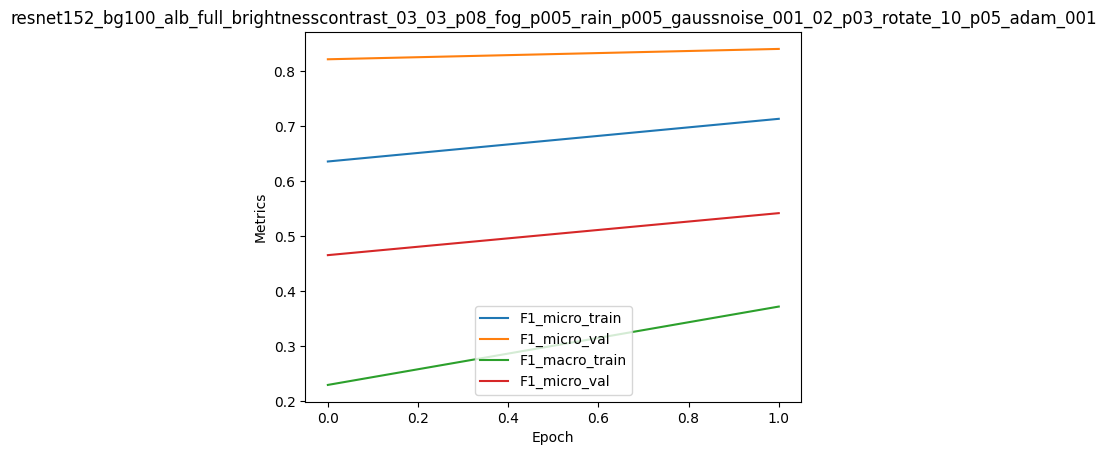

In [226]:
%matplotlib inline
fig, ax = plt.subplots()
ax.plot(train_f1_micros, label='F1_micro_train')
ax.plot(val_f1_micros, label='F1_micro_val')
ax.plot(train_f1_macros, label='F1_macro_train')
ax.plot(val_f1_macros, label='F1_micro_val')
ax.set_title(model_name)
ax.set(xlabel='Epoch', ylabel='Metrics')
ax.legend()
plt.show()